## Assignment

In this assignment, you'll continue working with the [U.S. Education Dataset](https://www.kaggle.com/noriuk/us-education-datasets-unification-project/home) from Kaggle. The data gives detailed state level information on the several facets of the state of education on annual basis. To learn more about the data and the column descriptions, you can view the Kaggle link above. You should access the data from the Thinkful database. Below are the credentials you can use to connect to the database:

postgres_user = 'dsbc_student'<br>
postgres_pw = '7\*.8G9QH21'<br>
postgres_host = '142.93.121.174'<br>
postgres_port = '5432'<br>
postgres_db = 'useducation'<br>

Don't forget to apply the most suitable missing value filling techniques you applied in the previous checkpoints to the data. You should provide your answers to the following questions after you handled the missing values.

To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

Say, we want to understand the relationship between the expenditures of the governments and the students' overall success in the math and reading.

1. Create a new score variable from the weighted averages of all score variables in the datasets. **Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!**.
2. What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?
3. Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?
4. What is the correlation between the overall score variable and the 1st principal component? 
5. If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

In [38]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sqlalchemy import create_engine
import warnings 

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [4]:
#read in data
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

edu = pd.read_sql_query('select * from useducation',con=engine)

In [7]:
#sort data 
edu = edu.sort_values(['STATE','YEAR'])
edu.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
52,1993_ALABAMA,ALABAMA,1993,727716.0,2827391.0,331409.0,1729295.0,766687.0,2833433.0,1564558.0,...,57497.0,60004.0,39900.0,470775.0,198651.0,677690.0,NaN,NaN,NaN,NaN
104,1994_ALABAMA,ALABAMA,1994,730004.0,2970223.0,331823.0,1850894.0,787506.0,3103266.0,1697593.0,...,56773.0,59165.0,41730.0,468472.0,201285.0,678808.0,NaN,NaN,NaN,NaN
157,1995_ALABAMA,ALABAMA,1995,727480.0,3367437.0,328957.0,2161366.0,877114.0,3353363.0,1851700.0,...,56486.0,59914.0,40981.0,470246.0,206840.0,686410.0,NaN,NaN,NaN,NaN
209,1996_ALABAMA,ALABAMA,1996,735912.0,3365113.0,334858.0,2138717.0,891538.0,3572283.0,1987018.0,...,57098.0,58305.0,42510.0,469370.0,207980.0,686983.0,211.646974,256.594863,210.920767,260.276441


In [22]:
#replace missing values using interpolation 

edu_df1= edu.copy()
edu_df2 = edu_df1.ffill()
edu_df = edu_df2.bfill()

In [23]:
edu_df.isnull().sum()/edu_df.isnull().count()

PRIMARY_KEY                     0.0
STATE                           0.0
YEAR                            0.0
ENROLL                          0.0
TOTAL_REVENUE                   0.0
FEDERAL_REVENUE                 0.0
STATE_REVENUE                   0.0
LOCAL_REVENUE                   0.0
TOTAL_EXPENDITURE               0.0
INSTRUCTION_EXPENDITURE         0.0
SUPPORT_SERVICES_EXPENDITURE    0.0
OTHER_EXPENDITURE               0.0
CAPITAL_OUTLAY_EXPENDITURE      0.0
GRADES_PK_G                     0.0
GRADES_KG_G                     0.0
GRADES_4_G                      0.0
GRADES_8_G                      0.0
GRADES_12_G                     0.0
GRADES_1_8_G                    0.0
GRADES_9_12_G                   0.0
GRADES_ALL_G                    0.0
AVG_MATH_4_SCORE                0.0
AVG_MATH_8_SCORE                0.0
AVG_READING_4_SCORE             0.0
AVG_READING_8_SCORE             0.0
dtype: float64

### 1. Create a new score variable from the weighted averages of all score variables in the datasets. **Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!** 

In [24]:
edu_df['w_g4'] = edu_df['GRADES_4_G'] / (edu_df['GRADES_4_G'] + edu_df['GRADES_8_G'])
edu_df['w_g8'] = edu_df['GRADES_8_G'] / (edu_df['GRADES_4_G'] + edu_df['GRADES_8_G'])


edu_df['score'] = ((edu_df['AVG_MATH_4_SCORE'] + edu_df['AVG_READING_4_SCORE'])*edu_df['w_g4'] + (edu_df['AVG_MATH_8_SCORE'] + edu_df['AVG_READING_8_SCORE'])*edu_df['w_g8'])/2

In [25]:
edu_df.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,w_g4,w_g8,score
0,1992_ALABAMA,ALABAMA,1992,727716.0,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,260.276441,0.499668,0.500332,232.204803
52,1993_ALABAMA,ALABAMA,1993,727716.0,2827391.0,331409.0,1729295.0,766687.0,2833433.0,1564558.0,...,470775.0,198651.0,677690.0,208.327876,252.187522,207.963517,260.276441,0.489332,0.510668,232.701823
104,1994_ALABAMA,ALABAMA,1994,730004.0,2970223.0,331823.0,1850894.0,787506.0,3103266.0,1697593.0,...,468472.0,201285.0,678808.0,208.327876,252.187522,207.963517,260.276441,0.489684,0.510316,232.684891
157,1995_ALABAMA,ALABAMA,1995,727480.0,3367437.0,328957.0,2161366.0,877114.0,3353363.0,1851700.0,...,470246.0,206840.0,686410.0,208.327876,252.187522,207.963517,260.276441,0.485275,0.514725,232.896914
209,1996_ALABAMA,ALABAMA,1996,735912.0,3365113.0,334858.0,2138717.0,891538.0,3572283.0,1987018.0,...,469370.0,207980.0,686983.0,211.646974,256.594863,210.920767,260.276441,0.494770,0.505230,235.106342


In [26]:
edu_df.columns

Index(['PRIMARY_KEY', 'STATE', 'YEAR', 'ENROLL', 'TOTAL_REVENUE',
       'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE',
       'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G', 'GRADES_ALL_G', 'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE',
       'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE', 'w_g4', 'w_g8', 'score'],
      dtype='object')

### 2. What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?

As we can see from the heatmap, support services expenditure is more correlated with student performance (r=0.17) than other types of expenditures. 

In [39]:
#correlation 
edu_exp = pd.DataFrame(edu_df[['INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 
                               'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE', 'score']])
edu_exp.head()

,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,score
0,1481703.0,735036.0,237222.0,174053.0,232.204803
52,1564558.0,794146.0,237222.0,204207.0,232.701823
104,1697593.0,826442.0,306977.0,231508.0,232.684891
157,1851700.0,888983.0,326956.0,243365.0,232.896914
209,1987018.0,935115.0,322883.0,286699.0,235.106342


In [40]:
def half_masked_corr_heatmap(dataframe, title=None, file=None):
    plt.figure(figsize=(5,5))
    sns.set(font_scale=1)
    
    mask = np.zeros_like(dataframe.corr())
    mask [np.triu_indices_from(mask)] = True
    
    with sns.axes_style("white"):
        sns.heatmap(dataframe.corr().round(2), mask=mask, annot=True, cmap='coolwarm')
        
    if title: plt.title(f'\n{title}\n', fontsize=18)
    plt.xlabel('')
    plt.ylabel('')
    if file: plt.savefig(file, bbox_inches='tight')
    plt.show();
    
    return 

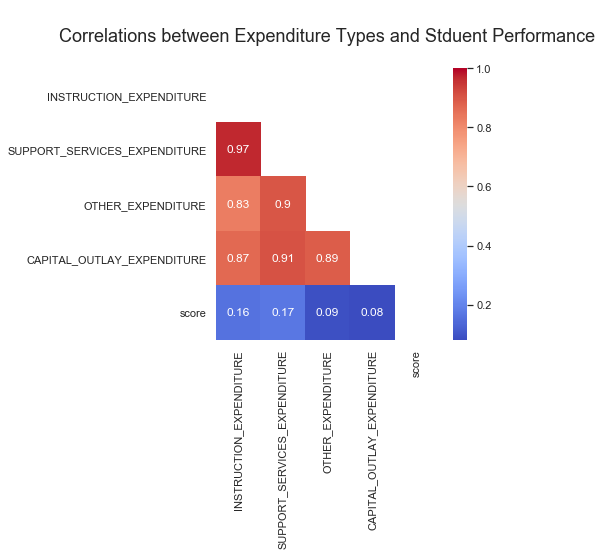

In [41]:
half_masked_corr_heatmap(edu_exp,
                         "Correlations between Expenditure Types and Stduent Performance"
                        )

### 3. Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?

More than 92% of the total variance is explained by the first component.

In [56]:
#Hobson: does it make sense to apply PCA to highly correlated variables r > 0.9?

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = edu_df[['INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 
            'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']]

X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=1)
edu_df["pca_1"] = sklearn_pca.fit_transform(X)

print(
    'The percent of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percent of total variance in the dataset explained by each component from Sklearn PCA.
 [0.92218992]


In [57]:
#play time
#apply PCA to those two expenditures that are more correlated with score

X = edu_df[['INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE']]
X = StandardScaler().fit_transform(X)
sklearn_pca = PCA(n_components=1)
edu_df["pca_2"] = sklearn_pca.fit_transform(X)

print(
    'The percent of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percent of total variance in the dataset explained by each component from Sklearn PCA.
 [0.98295505]


### 4. What is the correlation between the overall score variable and the 1st principal component? 

In [58]:
print(
    'The correlation between the overall score and the',
    '1st principle component is: \n',
    edu_df['score'].corr(edu_df['pca_1'])
)

The correlation between the overall score and the 1st principle component is: 
 0.12938485439874667


In [64]:
#play time

print(
    'The correlation between the overall score and the',
    '1st principle component is: \n',
    edu_df['score'].corr(edu_df['pca_2'])
)


The correlation between the overall score and the 1st principle component is: 
 0.16526759885265196


### 5. If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

I will choose support services expenditure over the PCA results because it has higher correlation than the 1st principle component. In addition, PCA works best when the variables have weak to moderatly strong correlation. In this case, correlations that are too high can result in components that are unstable. 